In [1]:
'''import packages'''
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
'''define function to calculate the net value for further use'''
def net_value(ret):
    log_ret = np.log(1+ret)
    net_ret = np.exp( log_ret.cumsum() )
    return net_ret

In [7]:
'''def two classes:  Trader class for profit calculation and brain class for strategy'''


class Trader():
    
    def __init__(self, value = 1, cost = 0, factors = 40):
        ''' start value as 1 and cost as 0
            40 factors to be invested
        
        '''
        self.value = value
        self.cost = cost
        self.factor_positions = np.zeros(factors)
        
        
    def allocate_position(self, positions):
        
        ''' input positions as list '''
        
        temp = self.factor_positions
        self.factor_positions = positions
        turnover = sum( np.abs(self.factor_positions - temp) )
        if self.validate_position():
            return turnover*self.value
    
    def validate_position(self):
        
        '''validate the position'''
        
        if sum(np.abs(self.factor_positions))>1.005:
            raise NameError('Sum of positions exceeds 1 !!!')
        if max(np.abs(self.factor_positions[:10])) > 0.2:
            raise NameError('style factors exceed risk cap!!!')
        if max(np.abs(self.factor_positions[11:])) > 0.05:
            raise NameError('industry factors exceed risk cap!!!')
        
        return True
    
    def calculate_value(self, factor_ret):
        self.value = self.value * ( 1 + np.sum(self.factor_positions * factor_ret) )
        ret = np.sum(self.factor_positions * factor_ret)
        return self.value, ret
    
class Brain():
    
    def __init__(self, data, data_net):
        self.ret_data = data
        self.ret_data_net = data_net
        self.market_view = 'normal'
        
    def view_market(self, short_days, long_days, date):
        
        ''' use the short term moving average and long term average to define the market state'''
        
        
        date_index = int(np.where([self.ret_data['date'] == date])[1])
        short_ma = self.ret_data_net['country'].rolling(short_days).mean()[date_index]
        long_ma = self.ret_data_net['country'].rolling(long_days).mean()[date_index]
        if short_ma > long_ma: ## if short term ma is higher than long term ma, we define the market as a bull market
            self.market_view = 'bull'
        else:
            self.market_view = 'bear'
        
    def mom(self, days, factors, start_date, end_date):
        
        '''
        generate momentum factor for asset allocation
        '''
        
        
        factor_index = np.where(self.ret_data.columns.isin(factors))[0]
        start_index = int(np.where([self.ret_data['date'] == start_date])[1])
        end_index =   int(np.where([self.ret_data['date'] == end_date])[1])      
        ret = self.ret_data.iloc[start_index: end_index+1, factor_index]
        for factor in ret.columns:
            ret[factor] = ret[factor].rolling(window = days).mean() #- ret[factor].rolling(window = days).std()
        return ret

In [4]:
'''load data and crete data with net value for better use'''
data  = pd.read_csv('factor_ret.csv')
data['date'] = pd.to_datetime(data['date'].astype(str))

data_net = data.copy()
data.dropna(inplace=True)
data.reset_index(inplace=True,drop=True)

data_net = data_net[data_net['date'] >= '2008-12-24']
data_net.reset_index(inplace=True,drop=True)
data_net.iloc[0, 1:] =0
data_net.iloc[:, 1:] = data_net.iloc[:, 1:].apply(lambda x: net_value(x))

In [5]:
data

,date,beta,momentum,size,earnings_yield,residual_volatility,growth,book_to_price,leverage,liquidity,...,industry20,industry21,industry22,industry23,industry24,industry25,industry26,industry27,industry28,industry29
0,2008-12-25,-0.002668,-0.000192,-0.002903,0.000671,-0.002254,0.001975,-0.001284,-0.002535,0.001795,...,0.004461,0.003162,0.007363,-0.001039,-0.010261,-0.003159,0.007756,0.001087,-0.037808,0.015956
1,2008-12-26,-0.001896,-0.001659,-0.000267,0.002952,-0.001799,0.003470,-0.000066,-0.002484,-0.001151,...,-0.003051,0.000664,0.020851,-0.012316,-0.008862,-0.001788,0.006567,0.010766,-0.009901,-0.005018
2,2008-12-29,-0.003144,0.000884,0.001429,0.000721,0.002879,-0.000533,-0.000221,0.001102,0.000560,...,0.004558,-0.009087,0.002406,0.000259,0.009480,-0.002269,-0.004000,0.014458,0.005417,0.001009
3,2008-12-30,-0.004923,-0.001592,-0.003611,-0.001999,0.000155,0.004068,-0.001102,-0.002369,-0.000323,...,-0.007860,0.008024,-0.001205,-0.011316,-0.004672,-0.000503,0.009675,0.004607,0.011866,0.011586
4,2008-12-31,-0.004172,0.001697,0.002512,0.001744,-0.001278,0.003511,0.000832,0.000086,-0.001287,...,-0.005898,-0.000950,0.007060,-0.000402,-0.003602,0.005041,0.022246,-0.003145,0.011752,0.006399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,2022-02-21,0.000131,-0.002808,-0.006625,-0.000412,0.002207,-0.002639,0.001518,0.001038,0.003289,...,0.000968,-0.005282,0.000452,-0.001115,-0.005515,-0.002817,0.021451,0.022425,0.003372,0.002164
3196,2022-02-22,0.002060,-0.000024,-0.000200,-0.000408,0.001027,-0.001626,-0.001703,0.001225,-0.001226,...,0.002556,0.007521,-0.002377,0.002483,-0.005728,0.002372,-0.004796,-0.005532,-0.022379,-0.001498
3197,2022-02-23,0.007935,0.002608,-0.000287,-0.001492,0.002369,0.002906,-0.002028,-0.000589,-0.003052,...,-0.023410,0.000524,0.005080,-0.011038,-0.003358,0.019321,0.001258,-0.002801,0.002367,0.001015
3198,2022-02-24,-0.001852,0.001607,0.001428,-0.000293,-0.000695,0.000304,-0.001268,0.000557,-0.002964,...,0.005867,0.000985,-0.011239,-0.005742,-0.006275,-0.000150,-0.007219,-0.020383,-0.020159,-0.007398


In [6]:
data_net

,date,beta,momentum,size,earnings_yield,residual_volatility,growth,book_to_price,leverage,liquidity,...,industry20,industry21,industry22,industry23,industry24,industry25,industry26,industry27,industry28,industry29
0,2008-12-24,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2008-12-25,0.997332,0.999808,0.997097,1.000671,0.997746,1.001975,0.998716,0.997465,1.001795,...,1.004461,1.003162,1.007363,0.998961,0.989739,0.996841,1.007756,1.001087,0.962192,1.015956
2,2008-12-26,0.995441,0.998150,0.996831,1.003625,0.995951,1.005452,0.998650,0.994988,1.000642,...,1.001397,1.003828,1.028368,0.986659,0.980968,0.995059,1.014374,1.011865,0.952665,1.010858
3,2008-12-29,0.992311,0.999032,0.998256,1.004348,0.998819,1.004916,0.998429,0.996084,1.001202,...,1.005961,0.994706,1.030842,0.986914,0.990268,0.992801,1.010317,1.026494,0.957826,1.011878
4,2008-12-30,0.987426,0.997442,0.994651,1.002340,0.998973,1.009004,0.997329,0.993725,1.000879,...,0.998054,1.002687,1.029599,0.975745,0.985641,0.992302,1.020092,1.031223,0.969191,1.023602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,2022-02-21,3.790499,1.200758,0.515055,1.550540,1.147154,1.402615,1.176921,0.854876,0.188937,...,1.229741,0.390732,0.321725,0.336010,0.333473,2.908480,1.819420,2.288495,1.473097,0.390829
3197,2022-02-22,3.798309,1.200730,0.514952,1.549906,1.148332,1.400334,1.174917,0.855923,0.188705,...,1.232884,0.393671,0.320960,0.336844,0.331563,2.915378,1.810695,2.275835,1.440130,0.390244
3198,2022-02-23,3.828447,1.203862,0.514805,1.547594,1.151053,1.404403,1.172534,0.855419,0.188129,...,1.204022,0.393877,0.322590,0.333127,0.330450,2.971705,1.812972,2.269461,1.443540,0.390640
3199,2022-02-24,3.821357,1.205796,0.515540,1.547140,1.150253,1.404830,1.171047,0.855895,0.187572,...,1.211086,0.394265,0.318965,0.331214,0.328376,2.971260,1.799885,2.223204,1.414439,0.387751


In [159]:

''' construct porfolio to save result'''
porfolio = pd.DataFrame(columns=[data.columns])
porfolio.insert(loc=1, column='cummulate_value', value = np.NaN)
porfolio.insert(loc=2, column='return', value = np.NaN)
porfolio

,date,cummulate_value,return,beta,momentum,size,earnings_yield,residual_volatility,growth,book_to_price,...,industry20,industry21,industry22,industry23,industry24,industry25,industry26,industry27,industry28,industry29


The main part of the strategy

In [160]:

##Since we use 150 momentum based strategy, we start on 2009-8-7 when we start getting the momentum factors
start_date, end_date = '2009-08-07', '2022-02-25'


brain = Brain(data, data_net)  ## Initialize brain and market view
factors = list(data.columns[1 :11])  ## no country factor
style_mom = brain.mom(150, factors, start_date, end_date).shift(1) ## Use the part 150 days momentum for style factor
factors = list(data.columns[12:]) 
industry_mom = brain.mom(150, factors, start_date, end_date).shift(1)## Use the part 150 days momentum for industry factor


trader = Trader() ## initialize trader


## initialize style positions and industry positions

style_positions = np.zeros(11) 
industry_positions = np.zeros(29)


## In a bull market, we want to select from "beta, momentum, growth, residual_volatility, leverage"
## In a bear market, we want to select from "beta, residual_volatility, book to ratio, earnings_yield, leverage, non_linear size"
bull_factor_index = [0, 4, 1, 5, 7] ## stands for  beta,residual_vol, momentum, growth,leverage  
bear_factor_index = [0, 4, 3, 6, 9] ## stands for  beta, residual_vol, earning_yield, book_to_price, non_linear_size, 



brain.view_market(20, 50, brain.ret_data['date'][149])  ## initialize market view on our first trading days

for i in range(150, len(brain.ret_data)):
    temp_style = list(style_mom.loc[i, :]) ## get the momentum factors
    temp_industry = list(industry_mom.loc[i, :])
    
    style_positions = np.zeros(11) ## initialize positions
    industry_positions = np.zeros(29)
    if i == 150 or i % 20 == 0:
        
        ## Allocate positions every 20 days
        
        if brain.market_view == 'bull':
            temp_style = sorted(range(len(temp_style)), key=lambda i: temp_style[i])
            
            long_factors = []
            short_factors = []
            for j in range(len(temp_style)):
                if (temp_style[len(temp_style) - 1 - j] in bull_factor_index) & (len(long_factors)<3) :
                    long_factors.append(temp_style[len(temp_style) - 1 - j])
                if (temp_style[j] in bear_factor_index) & (len(short_factors)<2):
                    short_factors.append(temp_style[j])
                    
            style_positions[long_factors] = [0.2, 0.1, 0.1]   ## long 3 style factors from the bull factors
            style_positions[short_factors] = [-0.2, -0.1]     ## short 2 factors from the bear factors
            
            long_factors = sorted(range(len(temp_industry)), key=lambda i: temp_industry[i])[-5:]
            short_factors = sorted(range(len(temp_industry)), key=lambda i: temp_industry[i])[:3]
            industry_positions[long_factors] = [0.05, 0.05, 0.025, 0.025, 0.025] ## long 4 industry with high momentum
            industry_positions[short_factors] = [-0.05, -0.05, -0.025]  ## short 2 industry with low momentum
            
        elif brain.market_view == 'bear':
            temp_style = sorted(range(len(temp_style)), key=lambda i: temp_style[i])
            
            long_factors = []
            short_factors = []
            for j in range(len(temp_style)):
                if (temp_style[len(temp_style) - 1 - j] in bear_factor_index) & (len(long_factors)<2) :
                    long_factors.append(temp_style[len(temp_style) - 1 - j])
                if (temp_style[j] in bull_factor_index) & (len(short_factors)<3):
                    short_factors.append(temp_style[j])
                    
            style_positions[long_factors] = [0.2, 0.1]   ## long 2 style factors from the bear factors
            style_positions[short_factors] = [-0.2, -0.1, -0.1] ## short 3 style factors from the bull factors
            
            long_factors = sorted(range(len(temp_industry)), key=lambda i: temp_industry[i])[-3:]
            short_factors = sorted(range(len(temp_industry)), key=lambda i: temp_industry[i])[:5]
            industry_positions[long_factors] = [0.05, 0.05, 0.025]   ## long 2 industry with high momentum
            industry_positions[short_factors] = [-0.05, -0.05, -0.025, -0.025, -0.025]  ## short 4 industry with low momentum
        
        
        positions = np.array(list(style_positions) + list(industry_positions))      
        trader.allocate_position(positions)  ## allocate positions
        
        #print(brain.market_view)  

        brain.view_market(20, 50, brain.ret_data['date'][i])  ## change market view at the end of the day
        #print(trader.factor_positions)

    p_value, p_return = trader.calculate_value(brain.ret_data.iloc[i,1:])  ## get the cummulate value and day return
    positions = list(trader.factor_positions)
    positions.insert(0, p_return)
    positions.insert(0, p_value)
    positions.insert(0, brain.ret_data['date'][i].date())
    porfolio = pd.concat([porfolio, pd.DataFrame([positions], columns = porfolio.columns)])
    #porfolio.append(p_value)
    #porfolio_return.append(p_return)
porfolio.reset_index(inplace=True, drop=True)

In [157]:
porfolio

,date,cummulate_value,return,beta,momentum,size,earnings_yield,residual_volatility,growth,book_to_price,...,industry20,industry21,industry22,industry23,industry24,industry25,industry26,industry27,industry28,industry29
0,2009-08-07,1.001721,0.001721,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
1,2009-08-10,1.000871,-0.000849,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
2,2009-08-11,1.001651,0.000779,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
3,2009-08-12,1.002693,0.001040,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
4,2009-08-13,0.999739,-0.002946,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3045,2022-02-21,2.058879,-0.000902,0.2,0.1,0.0,-0.1,-0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0
3046,2022-02-22,2.064260,0.002614,0.2,0.1,0.0,-0.1,-0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0
3047,2022-02-23,2.068599,0.002102,0.2,0.1,0.0,-0.1,-0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0
3048,2022-02-24,2.072338,0.001807,0.2,0.1,0.0,-0.1,-0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0


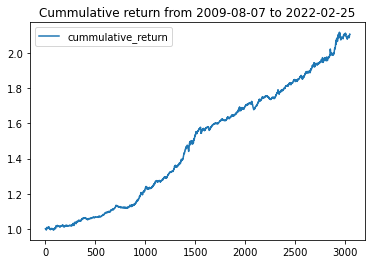

In [169]:
plt.plot(porfolio['cummulate_value'], label = 'cummulative_return')
plt.title('Cummulative return from 2009-08-07 to 2022-02-25')
plt.legend(loc = 'upper left')

In [162]:
''' sharpe ratio'''
porfolio['return'].mean() / porfolio['return'].std() * np.sqrt(252)

return    2.473792
dtype: float64

In [166]:
np.sum(np.abs(porfolio.iloc[:,-40:]), 1)

1.0000000000000002

In [167]:
np.sum(np.abs(porfolio.iloc[:,-40:]), 1).max()

1.0000000000000002

In [168]:
porfolio

,date,cummulate_value,return,beta,momentum,size,earnings_yield,residual_volatility,growth,book_to_price,...,industry20,industry21,industry22,industry23,industry24,industry25,industry26,industry27,industry28,industry29
0,2009-08-07,1.001824,0.001824,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
1,2009-08-10,1.000984,-0.000839,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
2,2009-08-11,1.001520,0.000536,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
3,2009-08-12,1.002725,0.001203,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
4,2009-08-13,0.999738,-0.002978,-0.2,0.0,0.0,-0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.025,0.025,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3045,2022-02-21,2.092056,-0.000834,0.2,0.1,0.0,-0.1,-0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0
3046,2022-02-22,2.097477,0.002591,0.2,0.1,0.0,-0.1,-0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0
3047,2022-02-23,2.102097,0.002203,0.2,0.1,0.0,-0.1,-0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0
3048,2022-02-24,2.106107,0.001907,0.2,0.1,0.0,-0.1,-0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0


In [ ]:
porfolio.to_csv('daily_position.csv')